# Monthly Mean Historical Hydrologic Variables from LOCA and BCSD

This notebook analyzes hydrologic variables from the historical scenario (1950-2005) from the LOCA and BCSD datasets. Each dataset is compared to its respective analog simulation run using gridded observations -- Livneh observations for LOCA and Maurer observations for BCSD.

Variables include:
- Total Runoff
- ET

In [1]:
from loca import print_date
print_date()

Last executed: 2019-10-04 14:00:02.706951 by jvano on casper20


# Imports and Options

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import cmocean

import xarray as xr

from loca.data_catalog import load_monthly_historical_hydro_datasets, load_monthly_cmip_hydro_datasets, resample_monthly_data
from loca.utils import calc_change
from loca.plot import make_plot, PROJECTION, add_ylabel
from cmocean import cm

# models currently using:
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1'] 

# list of 23:
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m',
#           'CESM1-BGC', 'CMCC-CM', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

models = ['ACCESS1-0', 'CanESM2']

#cache is written in script "write_cache.ipynb"  TODO
read_cache = True
# cache_dir = os.environ['TMPDIR']
cache_dir = '/glade/u/home/jvano/scratch/'

hydro_vars = ['ET', 'total_runoff', 'SWE']
kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
          'total_runoff': {'vmin': 0, 'vmax': 1000}, 'SWE': {'vmin': 0, 'vmax': 100},}
units = {'ET': 'mm', 'total_runoff': 'mm', 'SWE': 'mm'}

In [3]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://128.117.181.226:38451 Dashboard: proxy/8787/status,Cluster Workers: 2 Cores: 4 Memory: 60.00 GB


# Load Data

In [4]:
hist_cmip_data = {}
if read_cache:
    print("reading values from cache")
    for key in ['loca', 'bcsd']:
        hist_cmip_data[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_hydro_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
    print("finished reading from cache")
    ds = hist_cmip_data['loca']
    print(ds['total_runoff'])
    #TODO once get obs load separate won't have to do work around below
    single = ['ACCESS1-0']
    obs_data = load_monthly_historical_hydro_datasets(models=single, autoclose=True, parallel=True)
    #obs_data = load_monthly_historical_hydro_datasets(single, autoclose=True, parallel=True) #appears to work without "models"
    print("finished reading obs")
    # Merge two
    x = obs_data
    y = hist_cmip_data
    hydro_data = {**x, **y}

else:
    print("reading values from files directly")
    hydro_data = load_monthly_historical_hydro_datasets(models=models, autoclose=True, parallel=True)

reading values from cache
finished reading from cache
<xarray.DataArray 'total_runoff' (gcm: 23, time: 672, lat: 224, lon: 464)>
dask.array<shape=(23, 672, 224, 464), dtype=float32, chunksize=(1, 72, 224, 464)>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * gcm      (gcm) <U14 'ACCESS1-0' 'CESM1-BGC' ... 'bcc-csm1-1' 'inmcm4'
load_monthly_historical_hydro_datasets
load_monthly_cmip_hydro_datasets
load_monthly_loca_hydrology
load_daily_loca_hydrology
load_monthly_bcsd_hydrology
load_bcsd_dataset
load_monthly_livneh_hydrology
load_daily_livneh_hydrology
load_monthly_maurer_hydrology
finished reading obs


In [5]:
epoch = slice('1970-01-01', '1999-12-31')

mask = hydro_data['bcsd']['total_runoff'].isel(gcm=0, time=0).squeeze().notnull()

epoch_means = dict((k, ds.sel(time=epoch).mean('time').where(mask).persist())
                   for (k, ds) in hydro_data.items())
epoch_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').where(mask).persist()) for (k, ds) in hydro_data.items())

ens_means = dict((k, resample_monthly_data(ds.sel(time=epoch), freq='AS', chunks={'lat': 100, 'lon': 100}).mean('time').mean('gcm').where(mask).persist()) for (k, ds) in hist_cmip_data.items())

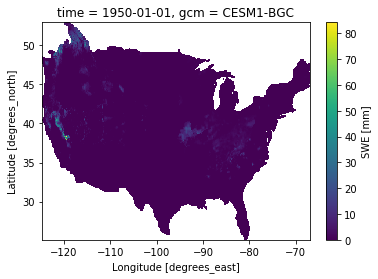

In [6]:
# test to see if plot:
hydro_data['bcsd']['SWE'].isel(gcm=1, time=0 ).plot()

# test to plot monthly (took a really long time, unsure if something wrong or computers glitchy)
# monthly = hydro_data['bcsd']['SWE'].groupby('time.month').mean('time').load()
# monthly.plot(col='month',col_wrap=3,robust=True)

# test to plot april
# monthly.sel(month=4).plot(robust=True)

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values
2. Maps of all datasets with LOCA and BCSD datasets plotted as differences relative to observation based VIC simulations 

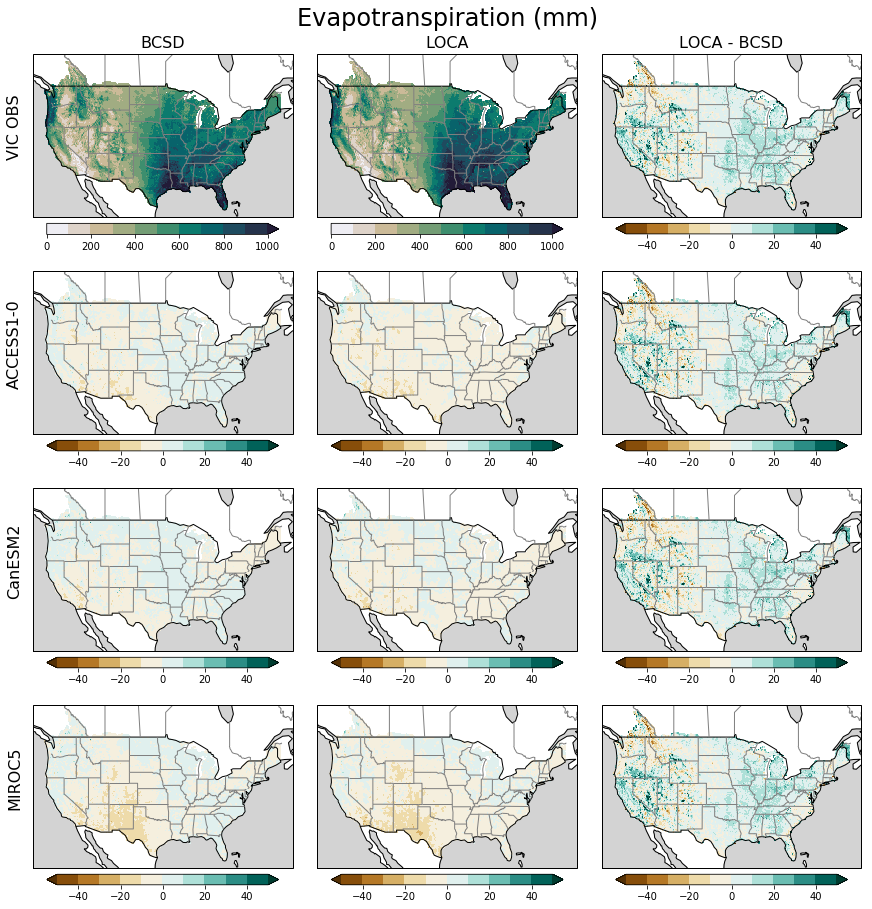

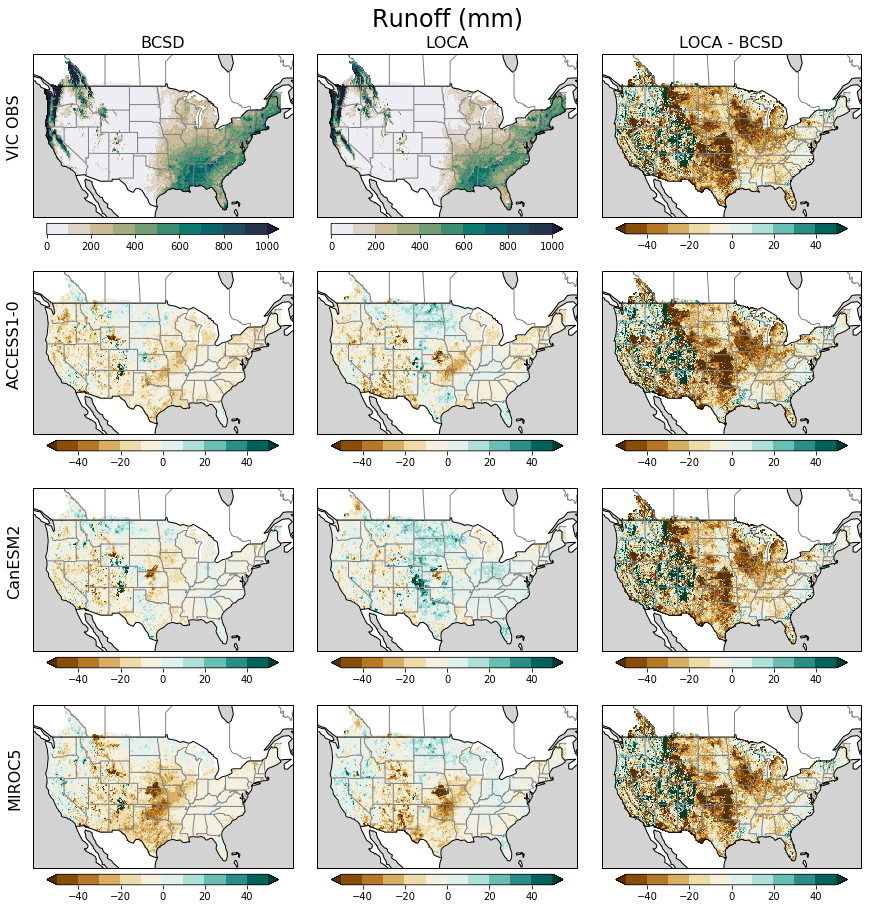

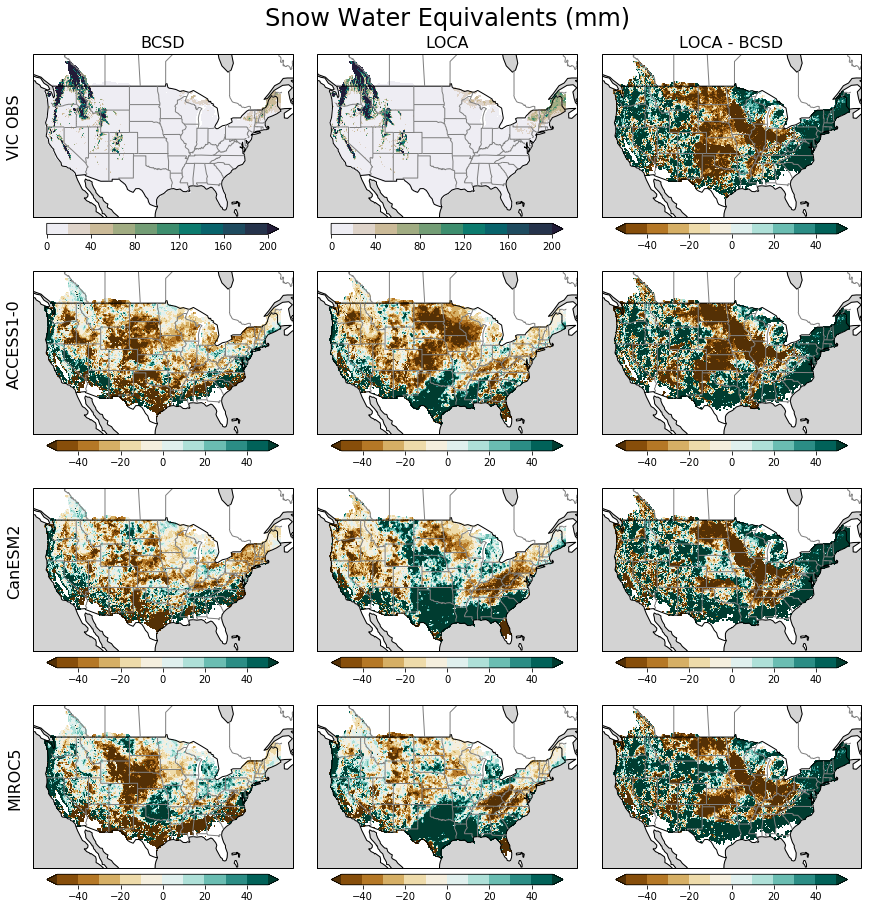

In [8]:
# Figure 6,7,8 (when pct=False), Figs in appendix when pct=True

watercmap = cm.rain  #https://matplotlib.org/cmocean/
watercmapdiff = 'BrBG'
tempcmapdiff = 'RdBu_r'

variablename = {'total_runoff': 'Runoff (mm)', 'SWE': 'Snow Water Equivalents (mm)', 'ET': 'Evapotranspiration (mm)'}

# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1']
models = ['ACCESS1-0', 'CanESM2', 'MIROC5'] 


style_kwargs =  {'levels': 11, 'add_labels': False, 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}
kwargs = {'ET': {'vmin': 0, 'vmax': 1000,'cmap':watercmap,  **style_kwargs},
          'total_runoff': {'vmin': 0, 'vmax': 1000, 'cmap':watercmap,  **style_kwargs},
          'SWE': {'vmin': 0, 'vmax': 200, 'cmap':watercmap,  **style_kwargs},}

diff_kws = {False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff, 'extend': 'both', **style_kwargs},
                    'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': watercmapdiff,  'extend': 'both', **style_kwargs},
                    'SWE': {'vmin': -50, 'vmax': 50, 'cmap': watercmapdiff, 'extend': 'both', **style_kwargs},},
            True: {'ET': {'vmin': -50, 'vmax': 50, 'cmap': watercmapdiff,  'extend': 'both', **style_kwargs},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': watercmapdiff, 'extend': 'both', **style_kwargs},
                   'SWE': {'vmin': -50, 'vmax': 50, 'cmap': watercmapdiff, 'extend': 'both', **style_kwargs}}}

nrows = 1 + len(models)
ncols = 2

hydro_vars = ['ET', 'total_runoff', 'SWE']
# hydro_vars = ['total_runoff']

for var in hydro_vars:
    
#     for pct in [False, True]:
    for pct in [False]:
        
        if var not in diff_kws[pct]:
            continue
    
        fig, axes = plt.subplots(ncols=ncols + 1, nrows=nrows, sharex=True, sharey=True, figsize=(12, 3.1*nrows), subplot_kw={'projection': PROJECTION})
        
        for col, (title, obs_data, ds_data) in enumerate([('BCSD', epoch_means['maurer'], epoch_means['bcsd']),
                                                          ('LOCA', epoch_means['livneh'], epoch_means['loca'])]):

            ax = axes[0, col]
            make_plot(obs_data[var], ax=ax, plot_kwargs=kwargs[var])  

            if col == 0:
                add_ylabel(ax, 'VIC OBS', fontsize=16)

            ax.set_title(title, fontsize=16)
    
            diff = calc_change(obs_data[var], ds_data[var], pct=pct).persist()
            for row, model in enumerate(models, 1):
                ax = axes[row, col]
                make_plot(diff.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[pct][var])  # JJH - added this line

                if col == 0:
                    add_ylabel(ax, model, fontsize=16)

        ax = axes[0, -1]
        diff = calc_change(epoch_means['maurer'][var], epoch_means['livneh'][var], pct=pct)
        make_plot(diff, ax=ax, plot_kwargs=diff_kws[pct][var])  # JJH - added this line
        ax.set_title('LOCA - BCSD', fontsize=16)

        diff = calc_change(epoch_means['bcsd'][var], epoch_means['loca'][var], pct=pct).persist()
        for row, model in enumerate(models, 1):
            ax = axes[row, -1]
            make_plot(diff.sel(gcm=model), ax=ax, plot_kwargs=diff_kws[pct][var])  # JJH - added this line

        
        title = var.upper()
        title += ' (%s)' % units[var]
        if pct:
            title += ' (%)'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(variablename[var], fontsize=24, y=1.02)
        fig.tight_layout()  
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff_{var}_{unit_str}_mon_hist_hydro.png', dpi=300, bbox_inches='tight')

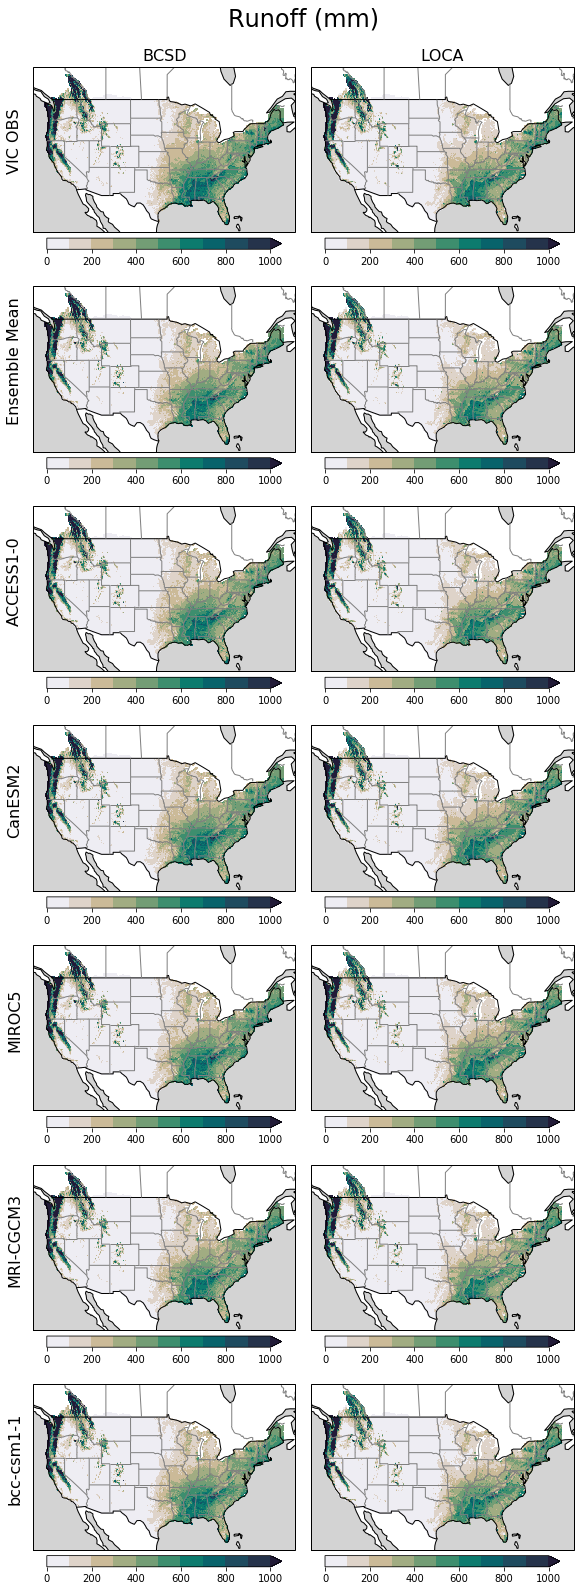

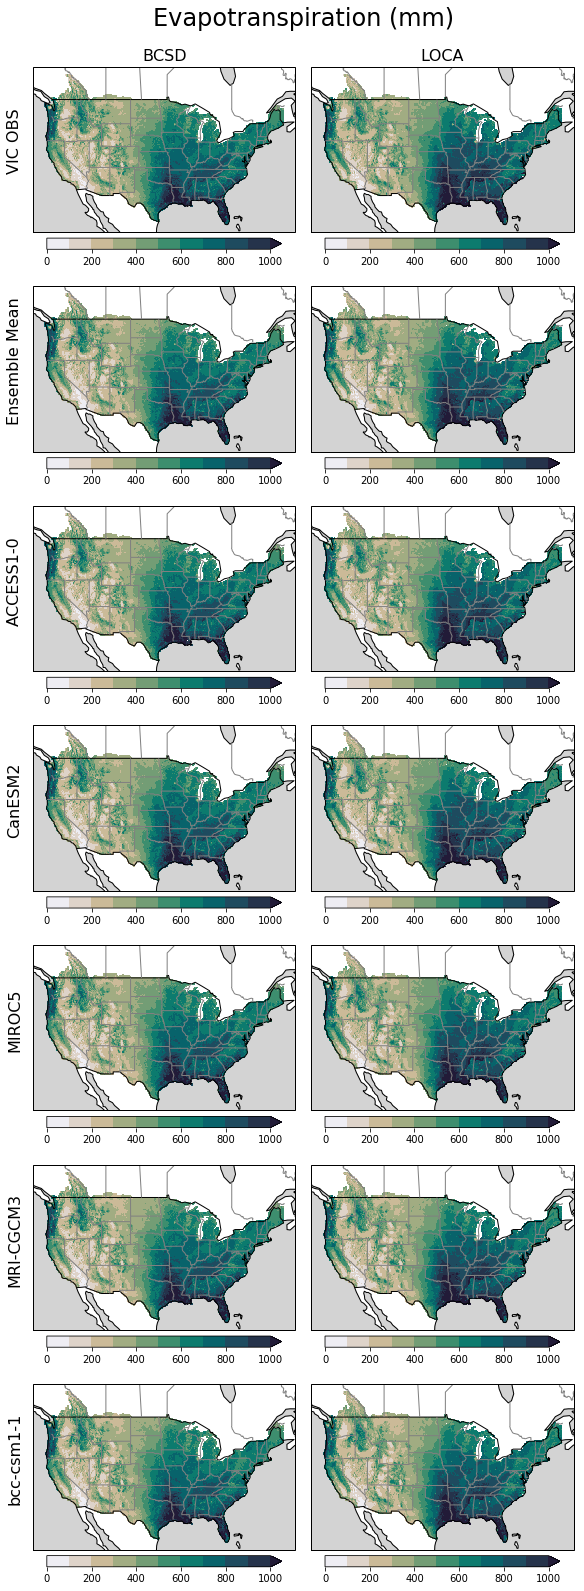

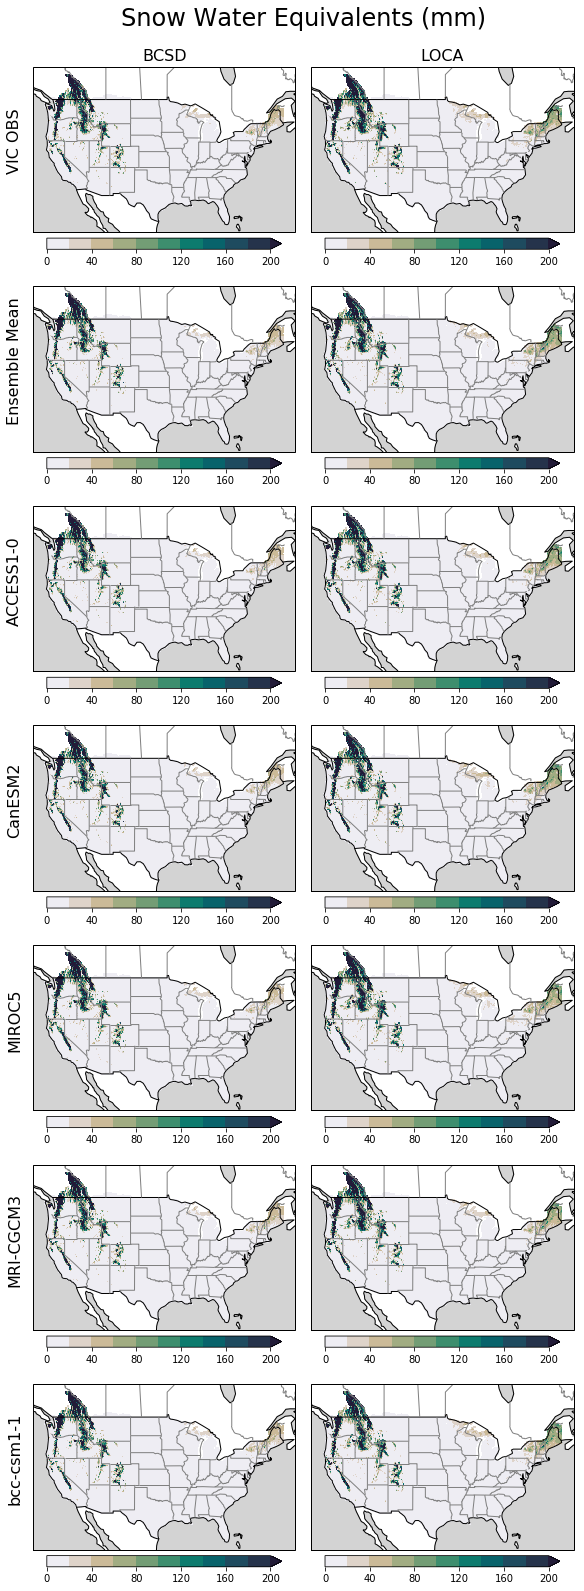

In [13]:
# hydro_vars = ['ET', 'total_runoff', 'SWE']

watercmap = cm.rain  #https://matplotlib.org/cmocean/
variablename = {'total_runoff': 'Runoff (mm)', 'SWE': 'Snow Water Equivalents (mm)', 'ET': 'Evapotranspiration (mm)'}

style_kwargs =  {'levels': 11, 'add_labels': False, 'cbar_kwargs': dict(orientation="horizontal", shrink=0.85, pad=0.03)}

hydro_vars = ['total_runoff', 'ET', 'SWE']
models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1']

kwargs = {'ET': {'vmin': 0, 'vmax': 1000, 'cmap': watercmap, **style_kwargs},
          'total_runoff': {'vmin': 0, 'vmax': 1000, 'cmap': watercmap, **style_kwargs}, 
          'SWE': {'vmin': 0, 'vmax': 200, 'cmap': watercmap, **style_kwargs},}
units = {'ET': 'mm', 'total_runoff': 'mm', 'SWE': 'mm'}

nrows = 2 + len(models)
ncols = 2

for var in hydro_vars:
    
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, sharex=True, sharey=True, figsize=(4*ncols, 3.1*nrows),subplot_kw={'projection': PROJECTION})
    
    for col, (title, obs_data, ensemble, ds_data) in enumerate([('BCSD', epoch_means['maurer'], ens_means['bcsd'], epoch_means['bcsd']),
                                                      ('LOCA', epoch_means['livneh'], ens_means['loca'], epoch_means['loca'])]):
        
        ax = axes[0, col]
#         obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        make_plot(obs_data[var], ax=ax, plot_kwargs=kwargs[var]) 
        ax.set_title(title, fontsize=16)
        
        if col == 0:
#             ax.set_ylabel('VIC OBS')
            add_ylabel(ax, 'VIC OBS', fontsize=16)
            
        ax = axes[1, col]
#         ensemble[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
        make_plot(ensemble[var], ax=ax, plot_kwargs=kwargs[var]) 
        
                
        if col == 0:
#             ax.set_ylabel('Ensemble Mean')
            add_ylabel(ax, 'Ensemble Mean', fontsize=16)

        
        for row, model in enumerate(models, 2):
            ax = axes[row, col]
#             ds_data[var].sel(gcm=model).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
#             obs_data[var].plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
            make_plot(ds_data[var].sel(gcm=model), ax=ax, plot_kwargs=kwargs[var])  

            
            if col == 0:
#                 ax.set_ylabel(model)
                add_ylabel(ax, model, fontsize=16)
                
#     title = var.upper()
    title = variablename[var]
#     title += ' (%s)' % units[var]
    unit_str = units[var]
    fig.suptitle(title, fontsize=24, y=1.02)
    fig.tight_layout()     
    fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{var}_{unit_str}_mon_hist_hydro.png', dpi=300, bbox_inches='tight')

In [ ]:
# cleanup 
plt.close('all')